# AAI-540 Group 6 Final Project

Authors: Alden Caterio, Gary Takahashi, Paul Parks

In [2]:
%pip install --disable-pip-version-check -q PyAthena
%pip install --disable-pip-version-check -q awswrangler
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import boto3
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
from time import gmtime, strftime, time
from botocore.client import ClientError
from pyathena import connect
import pandas as pd
import boto3
import sagemaker
import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## AWS S3 and Athena Setup

### Collect a raw data set and store it in an S3 Datalake.

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-048586998276


In [5]:
response = None
try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': '02GCQTJSZ4D2ARY3', 'HostId': 'jGqyulPTij4J2e2ZZKwE93PzfcPtcd+mLf32Tt5ERA43KDybFsgaQEui/lKvQRr8b8ppqCJGWeA=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'jGqyulPTij4J2e2ZZKwE93PzfcPtcd+mLf32Tt5ERA43KDybFsgaQEui/lKvQRr8b8ppqCJGWeA=', 'x-amz-request-id': '02GCQTJSZ4D2ARY3', 'date': 'Sat, 12 Oct 2024 03:11:14 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [6]:
filename = 'CEAS_08.csv'
local_csv_path = './dataset/' + filename

local_csv_path = 'dataset/CEAS_08.csv'

parquet_filename = filename.replace('.csv', '.parquet')  # Parquet file name
local_parquet_path = os.path.join('./dataset/', parquet_filename)

df = pd.read_csv(local_csv_path)
# Convert the CSV to Parquet
df['urls'] = df['urls'].astype(str)
df.to_parquet(local_parquet_path, engine='pyarrow')

folder_in_s3 = 'Dataset/'
s3_destination_path = f's3://{bucket}/{folder_in_s3}{parquet_filename}'
s3_destination_dir = f's3://{bucket}/{folder_in_s3}'

s3 = boto3.client('s3')

bucket_name = bucket
key = f'{folder_in_s3}{parquet_filename}'

s3.upload_file(local_parquet_path, bucket_name, key)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
if 'Contents' in response:
    print(f"File '{local_parquet_path}' uploaded successfully to '{s3_destination_path}'")
else:
    print(f"Failed to upload file to {s3_destination_path}")

File './dataset/CEAS_08.parquet' uploaded successfully to 's3://sagemaker-us-east-1-048586998276/Dataset/CEAS_08.parquet'


### Set up Athena tables to enable cataloging and querying of your data.

In [7]:
database_name = "spam_detection_db"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

/tmp/ipykernel_421/4249963361.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [8]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_421/1677879827.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,dsoaws
2,sagemaker_featurestore
3,spam_detection_db


In [9]:
table_name = "emails"
statement = f"""DROP TABLE IF EXISTS {database_name}.{table_name}"""
pd.read_sql(statement, conn)

/tmp/ipykernel_421/3526594799.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [10]:
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
    sender string,
    receiver string,
    date string,
    subject string,
    body string,
    label int,
    urls string
)
STORED AS PARQUET
LOCATION '{s3_destination_dir}'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

pd.read_sql(statement, conn)

/tmp/ipykernel_421/1329176703.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [11]:
statement = f"SHOW TABLES in {database_name}"

df_show = pd.read_sql(statement, conn)
print(df_show.head(5))

if table_name in df_show.values:
    print("[OK] Table created successfully.")
else:
    print("[ERROR] Table creation failed.")

/tmp/ipykernel_421/1698154721.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


  tab_name
0   emails
[OK] Table created successfully.


In [12]:
statement = f"""SELECT COUNT(*) AS total_rows
FROM {database_name}.{table_name}"""

result = pd.read_sql(statement, conn)
result.head(5)

/tmp/ipykernel_421/1710626760.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,total_rows
0,39154


In [13]:
statement = f"""SELECT * FROM {database_name}.{table_name} LIMIT 10"""

result = pd.read_sql(statement, conn)
result.head(10)

/tmp/ipykernel_421/1869399943.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql(statement, conn)


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
5,Caroline Aragon <dwthaidomainnamesm@thaidomain...,user7-ext5@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 05:31:22 +0600",From Caroline Aragon,\n\n\n\n\nYo wu urS mo ou go rc ebo eForM rgi ...,1,0
6,Replica Watches <jhorton@thebakercompanies.com>,user2.10@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 21:44:01 +0000",Replica Watches,We have fake Swiss Men's and Ladie's Replica \...,1,0
7,Daily Top 10 <acidirev_1972@tcwpg.com>,user2.3@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:41:14 -0300",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
8,qydlqcws-iacfym@issues.apache.org,xrh@spamassassin.apache.org,"Tue, 05 Aug 2008 15:31:03 -0800",[Bug 5780] URI processing turns uuencoded stri...,http://issues.apache.org/SpamAssassin/show_bug...,0,1
9,Daily Top 10 <orn|dent_1973@musicaedischi.it>,user7@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 00:31:38 +0100",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1


## AWS FeatureStore

### Test Train Split
Split your feature data into training (~40%), test (~10%) validation (~10%) datasets.
Reserve some data for “production data” (~40%).

In [14]:
feature_store_data = wr.athena.read_sql_query(f"SELECT * FROM {database_name}.{table_name}", database=database_name)

In [15]:
# Set up AWS clients and SageMaker session
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=region)
feature_store_session = Session(boto_session=boto_session, sagemaker_client=sagemaker_client, sagemaker_featurestore_runtime_client=featurestore_runtime)

# Define the S3 bucket for the offline store
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = "sagemaker-featurestore-spamdetection"

# Set up IAM role for SageMaker
role = get_execution_role()

In [16]:
# Create a FeatureGroup for the data
spamdetection_feature_group_name = "spamdetection-feature-group" + strftime("%d-%H-%M-%S", gmtime())
spamdetection_feature_group = FeatureGroup(name=spamdetection_feature_group_name, sagemaker_session=feature_store_session)

# Cast necessary columns to the right types
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

cast_object_to_string(feature_store_data)

In [17]:
from time import sleep
import uuid
current_time_sec = int(time())

feature_store_data['primary_key'] = [str(uuid.uuid4()) for _ in range(len(feature_store_data))]
feature_store_data['event_time'] = pd.Series([current_time_sec] * len(feature_store_data), dtype='float64')

# Record identifier and event time feature names
record_identifier_feature_name = 'primary_key'
event_time_feature_name = 'event_time'

# Load feature definitions from the DataFrame
spamdetection_feature_group.load_feature_definitions(data_frame=feature_store_data)

# Create the FeatureGroup in the SageMaker FeatureStore
spamdetection_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)


# Wait for the FeatureGroup to be created
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=spamdetection_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup spamdetection-feature-group12-03-11-35 successfully created.


## Exploratory Data Analysis

In [18]:
df = feature_store_data

In [19]:
# Display the first few rows of the dataset
df.head()

,sender,receiver,date,subject,body,label,urls,primary_key,event_time
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,082800e6-6d8b-44f8-a8a4-cbc99b8347d2,1.728703e+09
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,1,2c779d32-5771-4f4b-80ac-20624fc1c6bb,1.728703e+09
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,798e06ae-0408-4d99-bcea-16c400679b40,1.728703e+09
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,324e9e33-acb9-4d38-9fc3-e2baf9f13dd3,1.728703e+09
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,1,af58334c-ad31-4c1e-88e0-0cefa09bc8cd,1.728703e+09


In [20]:
# Get the shape of the dataset (number of rows and columns)
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 39154 rows and 9 columns.


In [21]:
# Get information about data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sender       39154 non-null  string 
 1   receiver     38692 non-null  string 
 2   date         39154 non-null  string 
 3   subject      39126 non-null  string 
 4   body         39154 non-null  string 
 5   label        39154 non-null  Int32  
 6   urls         39154 non-null  string 
 7   primary_key  39154 non-null  object 
 8   event_time   39154 non-null  float64
dtypes: Int32(1), float64(1), object(1), string(6)
memory usage: 2.6+ MB


In [22]:
# Get statistical summary of numerical columns
df.describe()

,label,event_time
count,39154.0,3.915400e+04
mean,0.557848,1.728703e+09
std,0.496649,0.000000e+00
min,0.0,1.728703e+09
25%,0.0,1.728703e+09
50%,1.0,1.728703e+09
75%,1.0,1.728703e+09
max,1.0,1.728703e+09


In [23]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sender           0
receiver       462
date             0
subject         28
body             0
label            0
urls             0
primary_key      0
event_time       0
dtype: int64


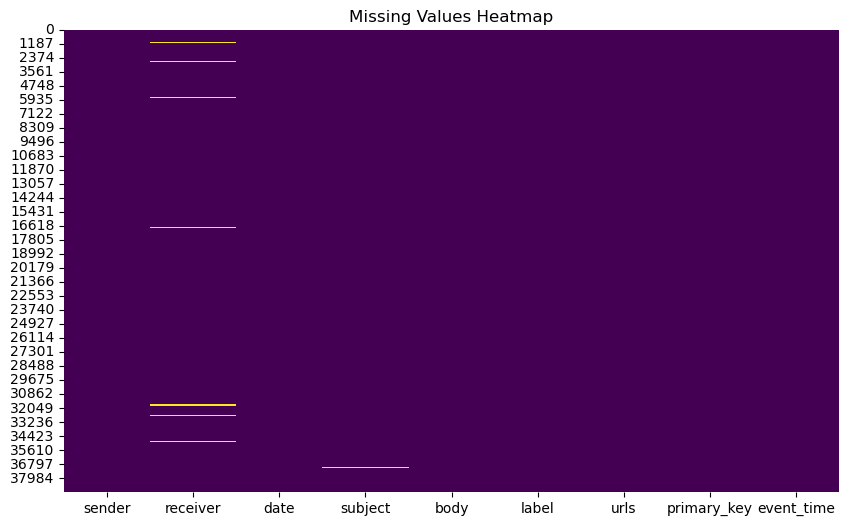

In [24]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [25]:
# Get the distribution of the target variable 'label'
label_counts = df['label'].value_counts()
print("Distribution of target variable 'label':")
print(label_counts)

Distribution of target variable 'label':
label
1    21842
0    17312
Name: count, dtype: Int64


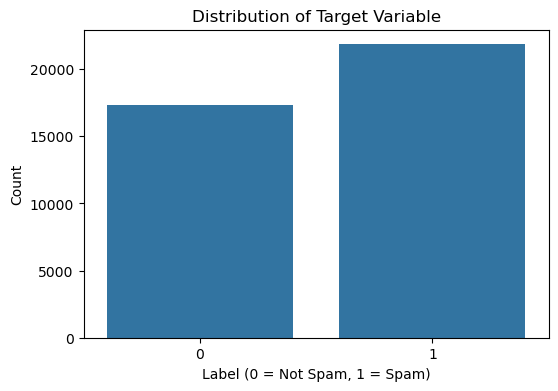

In [26]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()

In [27]:
# Check the number of unique senders and receivers
num_senders = df['sender'].nunique()
num_receivers = df['receiver'].nunique()
print(f"Number of unique senders: {num_senders}")
print(f"Number of unique receivers: {num_receivers}")

Number of unique senders: 24578
Number of unique receivers: 3693


In [28]:
# Top 10 most frequent senders
top_senders = df['sender'].value_counts().head(10)
print("Top 10 senders:")
print(top_senders)

Top 10 senders:
sender
qydlqcws-iacfym@issues.apache.org                 462
Guido van Rossum <hoauf@python.org>               295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>      276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>      208
Aaron Kulkis <cmiqlkx91@hotpop.com>               183
Rafael Garcia-Suarez <pvhuhqgncrxnu@gmail.com>    158
Christian Heimes <wluhe@cheimes.de>               152
Barry Warsaw <pjaxq@python.org>                   131
iybz@pobox.com                                    124
Per Jessen <uee@computer.org>                     113
Name: count, dtype: Int64


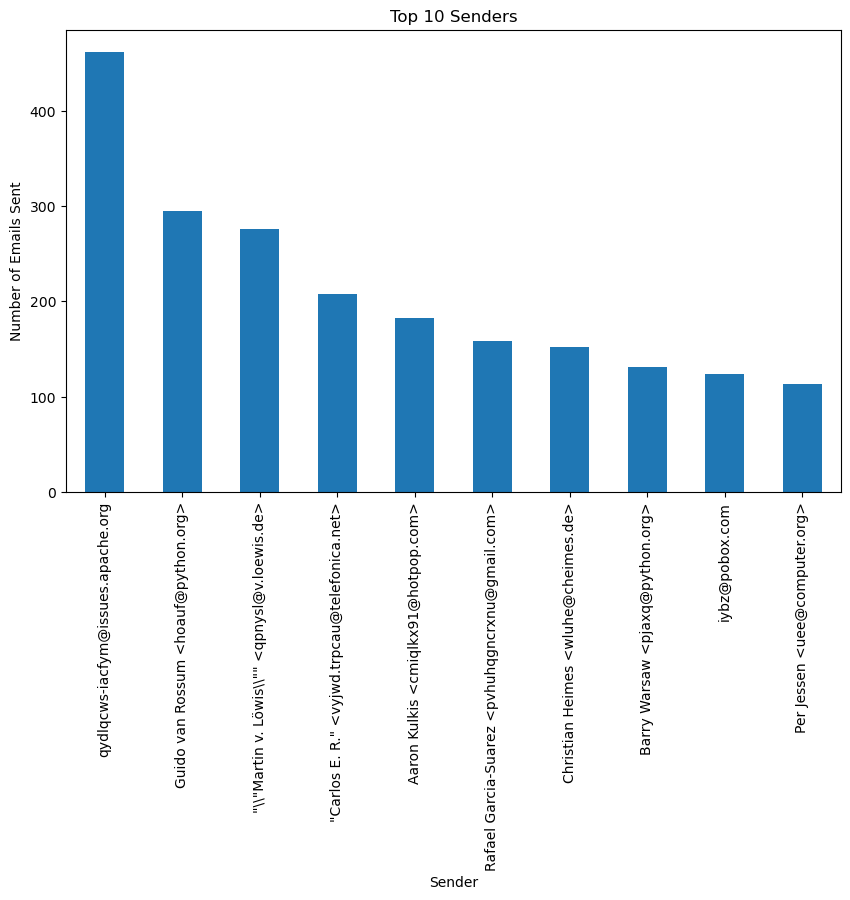

In [29]:
# Visualize top senders
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar')
plt.title('Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Number of Emails Sent')
plt.show()

In [30]:
# Create new features for the lengths of text fields
df['subject_length'] = df['subject'].astype(str).apply(len)
df['body_length'] = df['body'].astype(str).apply(len)
df['urls_length'] = df['urls'].astype(str).apply(len)

In [31]:
# Statistical summary of the text lengths
text_length_summary = df[['subject_length', 'body_length', 'urls_length']].describe()
print("Statistical summary of text lengths:")
print(text_length_summary)

Statistical summary of text lengths:
       subject_length    body_length  urls_length
count    39154.000000   39154.000000      39154.0
mean        38.899397    1571.079813          1.0
std         20.764513    3615.810576          0.0
min          1.000000      14.000000          1.0
25%         25.000000     224.000000          1.0
50%         35.000000     570.000000          1.0
75%         50.000000    1643.000000          1.0
max        285.000000  143996.000000          1.0


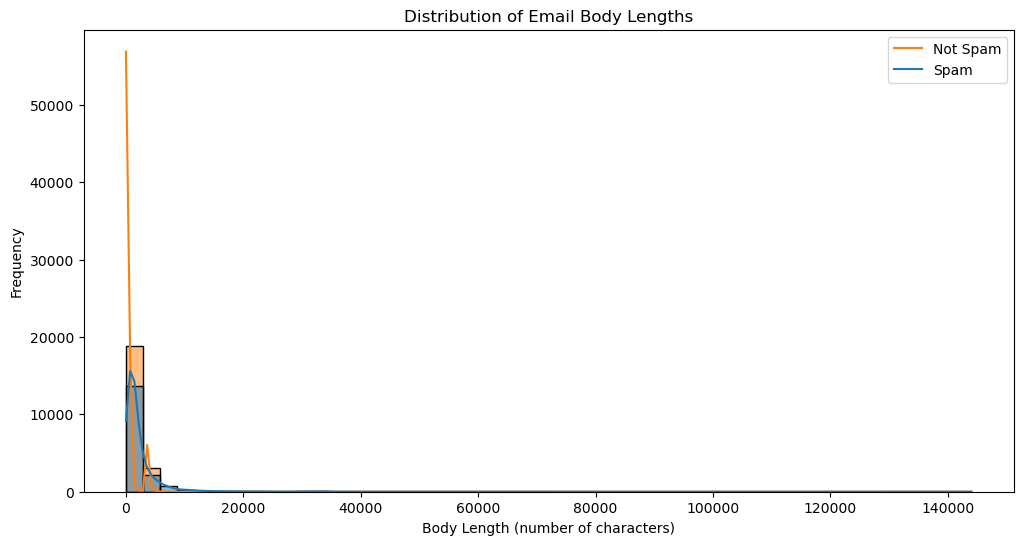

In [32]:
# Visualize the distribution of body lengths for spam and non-spam emails
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='body_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Email Body Lengths')
plt.xlabel('Body Length (number of characters)')
plt.ylabel('Frequency')
plt.legend(labels=['Not Spam', 'Spam'])
plt.show()

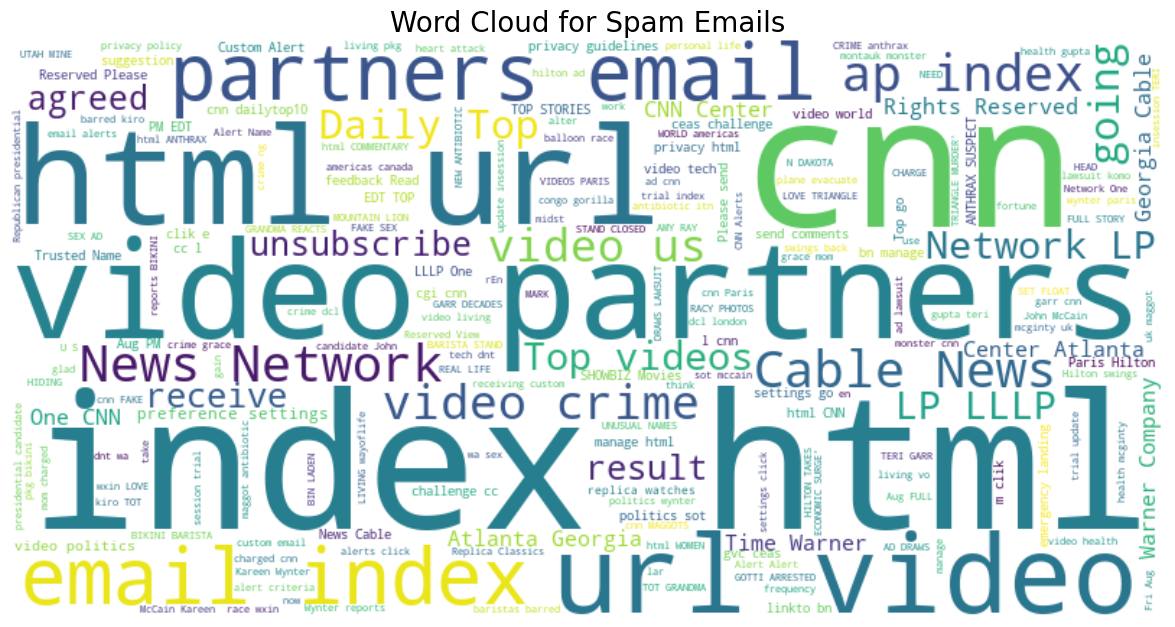

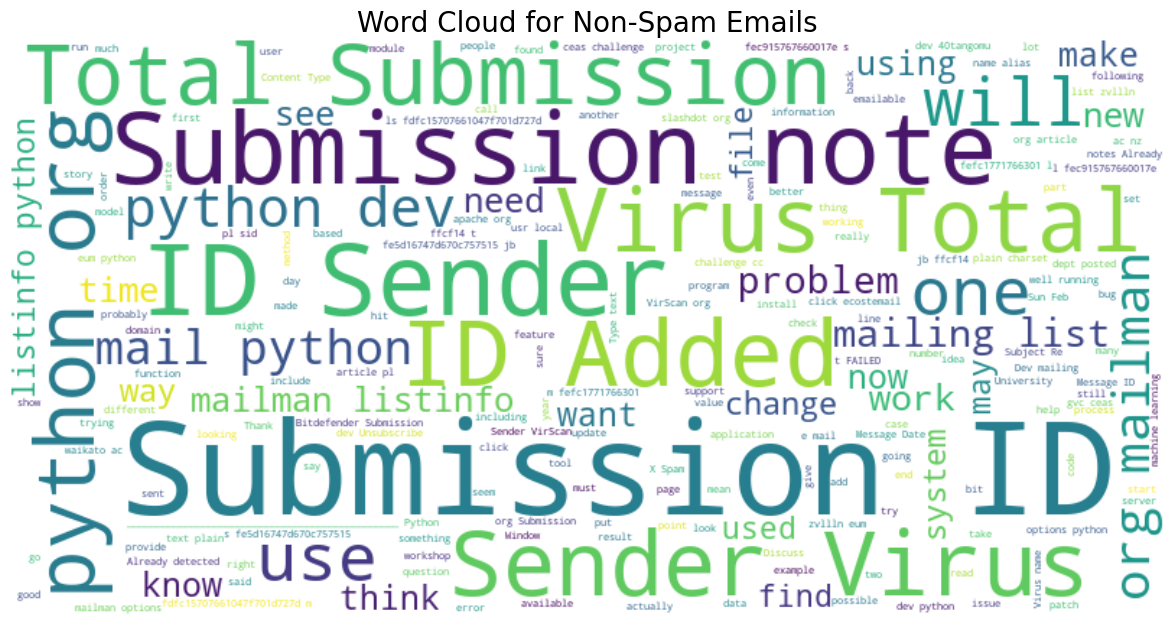

In [33]:
# Generate word clouds for spam and non-spam emails
spam_emails = df[df['label'] == 1]
non_spam_emails = df[df['label'] == 0]

def generate_wordcloud(text_data, title):
    text = ' '.join(text_data.dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Word cloud for spam emails
generate_wordcloud(spam_emails['body'], 'Word Cloud for Spam Emails')

# Word cloud for non-spam emails
generate_wordcloud(non_spam_emails['body'], 'Word Cloud for Non-Spam Emails')

In [34]:
# Create a DataFrame with numerical features
numerical_features = ['subject_length', 'body_length', 'urls_length']
numerical_df = df[numerical_features + ['label']]

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                subject_length  body_length  urls_length     label
subject_length        1.000000     0.063805          NaN -0.393957
body_length           0.063805     1.000000          NaN -0.239108
urls_length                NaN          NaN          NaN       NaN
label                -0.393957    -0.239108          NaN  1.000000


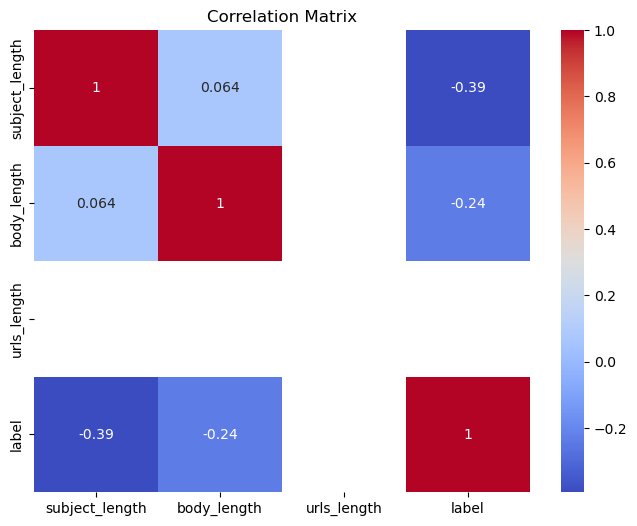

In [35]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model

In [36]:
# keep the original dataset untampered
# only using 10000 rows for now because kernel keeps crashing
df_new = df

# Combine subject and body
df_new['text'] = df_new['subject'] + ' ' + df_new['body']

In [37]:
df_new.head()

,sender,receiver,date,subject,body,label,urls,primary_key,event_time,subject_length,body_length,urls_length,text
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,082800e6-6d8b-44f8-a8a4-cbc99b8347d2,1.728703e+09,25,273,1,"Never agree to be a loser Buck up, your troubl..."
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tec...,1,1,2c779d32-5771-4f4b-80ac-20624fc1c6bb,1.728703e+09,22,82,1,Befriend Jenna Jameson Upgrade your sex and p...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,798e06ae-0408-4d99-bcea-16c400679b40,1.728703e+09,20,3918,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,324e9e33-acb9-4d38-9fc3-e2baf9f13dd3,1.728703e+09,150,24418,1,Re: svn commit: r619753 - in /spamassassin/tru...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iw...,1,1,af58334c-ad31-4c1e-88e0-0cefa09bc8cd,1.728703e+09,26,175,1,SpecialPricesPharmMoreinfo WelcomeFastShippin...


In [38]:
# Splitting 80% for training, 10% for testing, 10% for validation
df_production, df_train = train_test_split(df_new, test_size=0.80, random_state=42)
df_test, df_validation = train_test_split(df_production, test_size=0.50, random_state=42)

# Print the sizes of each split to confirm
print(f"Training data: {len(df_train)} rows")
print(f"Test data: {len(df_test)} rows")
print(f"Validation data: {len(df_validation)} rows")
print(f"Production data: {len(df_production)} rows")

Training data: 31324 rows
Test data: 3915 rows
Validation data: 3915 rows
Production data: 7830 rows


In [39]:
# Save the training data to CSV
df_train[['label', 'text']].to_csv('train.csv', index=False)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

prefix = 'benchmark-model'

train_input_path = sagemaker_session.upload_data('train.csv', bucket=bucket, key_prefix=f'{prefix}/train')

print(f'Training data uploaded to: {train_input_path}')

Training data uploaded to: s3://sagemaker-us-east-1-048586998276/benchmark-model/train/train.csv


### Train script
the following script will be output and used by the estimator

In [40]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

def model_fn(model_dir):
    """Load the model for inference"""
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    vectorizer = joblib.load(os.path.join(model_dir, "vectorizer.joblib"))
    return model, vectorizer

def predict_fn(input_data, model_and_vectorizer):
    """Vectorize string input and make predictions"""
    model, vectorizer = model_and_vectorizer
    
    # Check if the input data is a string (email body)
    # Transform the input string to TF-IDF features
    input_tfidf = vectorizer.transform([str(input_data)])
    input_dense = input_tfidf.toarray()  # Convert to dense format for GaussianNB

    # Make predictions using the trained model
    prediction = model.predict(input_dense)
    
    return prediction

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # SageMaker-specific arguments
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    
    args = parser.parse_args()
    
    # Read the training data
    train_data = pd.read_csv(os.path.join(args.train, 'train.csv'))
    
    # Separate features and target
    X_train = train_data['text'].astype(str)
    y_train = train_data['label']
    
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=10000)    
    X_train_tfidf = vectorizer.fit_transform(X_train)
   
    # Convert sparse matrix to dense for GaussianNB
    X_train_dense = X_train_tfidf.toarray()
    
    # Train the model
    # Build a Naive Bayes Classifier
    model = GaussianNB()
    
    model.fit(X_train_dense, y_train)
    
    # Save the model
    joblib.dump(model, os.path.join(args.model_dir, "model.joblib"))
    joblib.dump(vectorizer, os.path.join(args.model_dir, "vectorizer.joblib"))


Overwriting train.py


### Train the model

In [41]:
from sagemaker.sklearn.estimator import SKLearn

role = sagemaker.get_execution_role()

sklearn_estimator = SKLearn(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    framework_version='0.23-1',
    py_version='py3',
    output_path=f's3://{bucket}/{prefix}/output'
)

# Run the training job
sklearn_estimator.fit({'train': train_input_path})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-10-12-03-12-54-979


2024-10-12 03:12:55 Starting - Starting the training job...
2024-10-12 03:13:12 Starting - Preparing the instances for training...
2024-10-12 03:13:45 Downloading - Downloading input data...
2024-10-12 03:14:15 Downloading - Downloading the training image...
2024-10-12 03:14:51 Training - Training image download completed. Training in progress..2024-10-12 03:14:55,072 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-10-12 03:14:55,075 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-12 03:14:55,118 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-10-12 03:14:55,302 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-12 03:14:55,315 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-12 03:14:55,327 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-12 03:

## Deploy the trained model

In [42]:
from datetime import datetime, timedelta, timezone

# define endpoint name
endpoint_name = f"naivebayes-spam-detection-model-quality-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = naivebayes-spam-detection-model-quality-monitor-2024-10-12-0316


In [43]:
# Deploy the model to an endpoint
predictor = sklearn_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=endpoint_name   # Adding endpoint name for model monitoring purposes
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-10-12-03-16-07-769
INFO:sagemaker:Creating endpoint-config with name naivebayes-spam-detection-model-quality-monitor-2024-10-12-0316
INFO:sagemaker:Creating endpoint with name naivebayes-spam-detection-model-quality-monitor-2024-10-12-0316


------!

### Test Inference

In [44]:
test_email_subject = "Test Email"
test_email_body = "Hi this is not spam I promise"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[1]


In [45]:
test_email_subject = "Project docs"
test_email_body = "I will send you the project doc later today"
test_email = test_email_subject + ' ' + test_email_body
print(predictor.predict(str(test_email)))

[0]


### Run inference for evaluation

In [46]:
# Prepare test data
X_test = df_test['text']
y_test = df_test['label']

In [47]:
# Set the serializer and deserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Make predictions
predicted_labels = []
for email_body in X_test:
    prediction = predictor.predict(str(email_body))
    predicted_labels.append(int(prediction[0]))

# Compare predictions with actual labels
print(predicted_labels[0:20])

[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]


## Evaluation

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Benchmark Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Benchmark Model Performance:
Accuracy: 0.9862
Precision: 0.9963
Recall: 0.9792
F1 Score: 0.9877


## Monitoring

In [49]:
df_validation.head()

,sender,receiver,date,subject,body,label,urls,primary_key,event_time,subject_length,body_length,urls_length,text
1946,Hans Linux <ramy.jsnsv@igi-alliance.com>,opensuse <wkilxloc@opensuse.org>,"Wed, 06 Aug 2008 08:22:37 +0700",[opensuse] Camorama error,"I hv an error with camorama, dont know how to ...",0,0,466f16ec-2fe3-436d-a641-69b5fe3ec81a,1.728703e+09,25,265,1,[opensuse] Camorama error I hv an error with c...
15515,Ulysses Merritt <Ulysses@dom.de>,user2.2@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 01:38:29 -1600",Unbelievably cheap high fashion watch,These impeccable stylish minutiae will add mor...,1,1,c3e5b37a-88e5-4fae-a323-293070febe31,1.728703e+09,37,91,1,Unbelievably cheap high fashion watch These im...
6691,Martin List-Petersen <qpnysl@list-petersen.dk>,FRLinux <osaagqc@gmail.com>,"Wed, 06 Aug 2008 02:59:54 +0100",Re: [ILUG] Broadband in Dublin,"FRLinux wrote: > On 10/8/07, Martin List-Peter...",0,0,787e7750-edd4-4ac1-b719-16806e32227c,1.728703e+09,30,781,1,Re: [ILUG] Broadband in Dublin FRLinux wrote: ...
14799,Rafael Garcia-Suarez <pvhuhqgncrxnu@gmail.com>,"""Jerry D. Hedden"" <drbcqzxl@cpan.org>","Wed, 06 Aug 2008 22:22:52 +0200",Re: [PATCH] Fix overloading for 64-bit ints (r...,"On 20/10/2007, Rafael Garcia-Suarez wrote: > ...",0,0,d3d5a6a0-865b-4871-902d-7bf275f17cb0,1.728703e+09,53,187,1,Re: [PATCH] Fix overloading for 64-bit ints (r...
1307,Skip Montanaro <dwooqfuug@users.sourceforge.net>,pnperxdpv-sarswdlp@python.org,"Tue, 05 Aug 2008 17:28:25 -0700",[Spambayes-checkins] spambayes/spambayes XMLRP...,Update of /cvsroot/spambayes/spambayes/spambay...,0,1,ce47344d-fc28-4375-894a-448e87afde2c,1.728703e+09,74,2412,1,[Spambayes-checkins] spambayes/spambayes XMLRP...


The feature "label" is the prediction feature.

In [50]:
df_validation_new = df_validation[['text','label']]
df_validation_new.head()

,text,label
1946,[opensuse] Camorama error I hv an error with c...,0
15515,Unbelievably cheap high fashion watch These im...,1
6691,Re: [ILUG] Broadband in Dublin FRLinux wrote: ...,0
14799,Re: [PATCH] Fix overloading for 64-bit ints (r...,0
1307,[Spambayes-checkins] spambayes/spambayes XMLRP...,0


In [51]:
# Generate CSV from the DataFrame
validate_dataset = "validation_dataset.csv"
# df_validation_new.to_csv(validate_dataset, index=False)

In [52]:
limit = 200  # Need at least 200 samples to compute standard deviations
spam_cutoff = 0.8
i = 0
with open(f"{validate_dataset}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label\n")  # our header
    # with open("validation.csv", "r") as f:
    for row in df_validation_new.values:
        label = row[1]
        probability = float(predictor.predict(row[0]))
        prediction = "1" if probability > spam_cutoff else "0"
        baseline_file.write(f"{probability},{prediction},{label}\n")
        i += 1
        if i > limit:
            break
        print(".", end="", flush=True)
        sleep(0.5)
print()
print("Done!")

.

/tmp/ipykernel_421/822773150.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probability = float(predictor.predict(row[0]))


.......................................................................................................................................................................................................
Done!


In [53]:
!head validation_dataset.csv

probability,prediction,label
0.0,0,0
1.0,1,1
0.0,0,0
0.0,0,0
0.0,0,0
0.0,0,0
0.0,0,0
1.0,1,1
0.0,0,0


### Upload the predictions as a baseline dataset
Now we will upload the predictions made using validation dataset to S3 which will be used for creating model quality baseline statistics and constraints

In [54]:
# Initialize baseline details and names
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/results


In [55]:
from sagemaker.s3 import S3Downloader, S3Uploader

baseline_dataset_uri = S3Uploader.upload(f"{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-east-1-048586998276/benchmark-model/baselining/data/validation_dataset.csv'

### Create a baselining job
Define the model quality monitoring object and execute the model quality monitoring baseline job. Model monitor will automatically generate baseline statistics and constraints based on the validation dataset provided.

In [56]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [57]:
# need to get Session without boto3
session_2 = Session()

In [58]:
# Create the model quality monitoring object
spam_detection_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session_2,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [59]:
# Name of the model quality baseline job
baseline_job_name = f"naivebayes-spam-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [60]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = spam_detection_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name naivebayes-spam-model-baseline-job-2024-10-12-0322


...........................................................!

### Explore baselining job results
You could see the baseline constraints and statistics files are uploaded to the S3 location.

In [61]:
baseline_job = spam_detection_quality_monitor.latest_baselining_job

#### View generated metrics
You could see that the baseline statistics and constraints files are already uploaded to S3.

In [62]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,101
confusion_matrix.0.1,0
confusion_matrix.1.0,3
confusion_matrix.1.1,97
recall.value,0.97
recall.standard_deviation,0.009787
precision.value,1.0
precision.standard_deviation,0.0
accuracy.value,0.985075
accuracy.standard_deviation,0.004859


#### View generated constraints

In [63]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.97,LessThanThreshold
precision,1.0,LessThanThreshold
accuracy,0.985075,LessThanThreshold
true_positive_rate,0.97,LessThanThreshold
true_negative_rate,1.0,LessThanThreshold
false_positive_rate,0.0,GreaterThanThreshold
false_negative_rate,0.03,GreaterThanThreshold
auc,0.985,LessThanThreshold
f0_5,0.993852,LessThanThreshold
f1,0.984772,LessThanThreshold


# FROM ALDEN: I was able to get up to this point.

###  Generate artificial data for Model Quality Monitoring

Generate artificial traffic.

In [65]:
df_test.head()

,sender,receiver,date,subject,body,label,urls,primary_key,event_time,subject_length,body_length,urls_length,text
9175,cormier@qigong-schweiz.ch,user2.11@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 13:56:52 +0700",Here is your E-greeting,Your friend has sent you an Ecard from WorldP...,1,1,e79a83be-c842-4a69-baac-5303f5c7a311,1.728699e+09,23,203,1,Here is your E-greeting Your friend has sent ...
22473,Daily Top 10 <terressa-'elecnoc@techresults-nv...,user8.2-ext1@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 11:14:12 +0200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,c967293f-f66d-452c-8341-48295b52f927,1.728699e+09,20,3902,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
30075,Alberta Zimmerman <gerard.de.graan@mxi.nl>,user2.4@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 22:34:20 +0200","For you color=""#006631""",======================================== lover...,1,1,40472494-ba50-424c-9aa2-9332f7bde0fc,1.728699e+09,24,608,1,"For you color=""#006631"" =====================..."
14605,Essie Blanco <DeliacarboyBlanco@pipl.com>,user2.14@gvc.ceas-challenge.cc,"Wed, 06 Aug 2008 12:36:52 +0500",Dreams can cost less Replica watches from Role...,Ready to Ship Now !! 100% money back Guarant...,1,1,265caf80-ac3d-4081-bebb-cc3e5fdd22b7,1.728699e+09,55,173,1,Dreams can cost less Replica watches from Role...
33402,InfoWorld Online Resources <spqegm_vppepjbrp@i...,user6@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 22:20:47 -0500",Forget One-Size-Fits-All SCM,Two thirds of all software projects fail accor...,0,1,6e275994-2261-4a7e-8ab2-40ca3360e059,1.728699e+09,28,804,1,Forget One-Size-Fits-All SCM Two thirds of all...


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)   
X_test = X_test.dropna()
X_test_tfidf = vectorizer.fit_transform(X_test)
X_test_dense = X_test_tfidf.toarray()

In [66]:
np.shape(X_test_dense[0:5])

(5, 10000)

In [67]:
df_temp = pd.DataFrame(X_test_dense)
df_temp.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.076478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_test['label'].head()

9175     1
22473    1
30075    1
14605    0
33402    0
Name: label, dtype: Int32

# Need to figure out why the very last column [10001] contains NAs

In [69]:
df_test_new = pd.concat([df_temp, df_test['label']], axis=1, ignore_index=True)
df_test_new.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
3,0.0,0.0,0.076478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<NA>


In [86]:
# Upload test dataset as csv
test_dataset = "test_dataset.csv"
df_test_new.to_csv(test_dataset, index=False)

In [88]:
from threading import Thread

def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session_2.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_dataset.csv")
        except session_2.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

Exception in thread Thread-11 (invoke_endpoint_forever):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_18/3162125516.py", line 21, in invoke_endpoint_forever
  File "/tmp/ipykernel_18/3162125516.py", line 8, in invoke_endpoint
  File "/opt/conda/lib/python3.10/site-packages/botocore/client.py", line 565, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/botocore/client.py", line 1021, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server e

# Cleanup to avoid AWS fees

In [110]:
spam_detection_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

INFO:sagemaker:Deleting Monitoring Schedule with name: None


ParamValidationError: Parameter validation failed:
Invalid type for parameter MonitoringScheduleName, value: None, type: <class 'NoneType'>, valid types: <class 'str'>

In [111]:
# Delete the endpoint to avoid charges
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: naivebayes-spam-detection-model-quality-monitor-2024-10-11-2226
INFO:sagemaker:Deleting endpoint with name: naivebayes-spam-detection-model-quality-monitor-2024-10-11-2226
